In [1]:
# ignore this
%load_ext music21.ipython21

# User's Guide, Chapter 6: Streams (II): Hierarchies, Recursion, and Flattening

We ended Chapter 4 (:ref:`Streams (I) <usersGuide_04_stream1>`.) with a :class:`~music21.stream.Stream` that was
contained within another `Stream` object.  Let's recreate that class:

In [2]:
from music21 import *

note1 = note.Note("C4")
note1.duration.type = 'half'
note2 = note.Note("F#4")
note3 = note.Note("B-2")

stream1 = stream.Stream()
stream1.id = 'some notes'
stream1.append(note1)
stream1.append(note2)
stream1.append(note3)

biggerStream = stream.Stream()
note2 = note.Note("D#5")
biggerStream.insert(0, note2)
biggerStream.append(stream1)

The only way to find out what was in the contained
Stream that we demonstrated so far was the :meth:`~music21.base.Music21Object.show` method
using the `('text')` argument.

In [3]:
biggerStream.show('text')

{0.0} <music21.note.Note D#>
{1.0} <music21.stream.Stream some notes>
    {0.0} <music21.note.Note C>
    {2.0} <music21.note.Note F#>
    {3.0} <music21.note.Note B->


As Chapter 4 noted, there's a way to reach the inner notes such as `F#` via the `biggerStream[1][2]` format, but there's a better way to do that in music21, and for that we need to learn about subclasses of Streams and subclasses in general. (Skip this if you already know about such things from other programming experience)

## Classes and Subclasses

An object, such as a note or pitch, is basically a collection of information along with some actions that can be performed on that information.  A class is something that can make new objects of a certain type (sometimes this is called a factory).  We've seen classes such as the `note.Note` class, where the lowercase `note` is the "module" that the class `Note` lives in:

In [4]:
#_DOCS_SHOW note
print("<module 'music21.note' from '/Users/cuthbert/music21/note.py'>") #_DOCS_HIDE

<module 'music21.note' from '/Users/cuthbert/music21/note.py'>


In [5]:
print(note.Note)

<class 'music21.note.Note'>


We create an object from a class by using the class name with `()` after it:

In [6]:
n = note.Note()
n

<music21.note.Note C>

As we've seen, we can sometimes put additional information into the `()`, such as a pitch name in the case of a `Note`:

In [7]:
d = note.Note('D#5')
d

<music21.note.Note D#>

The variable `d` is now a `Note` object created from the `Note` class.  It's all a bit confusing, I know.  But we'll get to the point in a second.  If you want to find out more about what a `Note` object can do, the best thing is to read the `music21` instruction manual. :-) But for any class in Python, you can use the function `help(Class)` to find out what it can do:

In [8]:
#_DOCS_SHOW help(note.Note)

Notice towards the very top there's the line `class Note(NotRest)`.  This says that the `Note` class is a "subclass" of a class called `NotRest` which contains all the information for note-like things such as `Note`, `Unpitched` percussion, and `Chord` that have stems, beams, etc. and are, well, not rests.  (Chris Ariza and I spent over an hour trying to come up with a better name for these things, but in the end we couldn't come up with anything better than `NotRest`, so it's stuck).

What does it mean for `Note` to be a subclass of `NotRest`? It means that everything that `NotRest` can do, `Note` can do, and more. For instance, `NotRest` has a `.beams` property, so so does `Note`:

In [9]:
nr = note.NotRest()
n = note.Note()
print(nr.beams, n.beams)

<music21.beam.Beams > <music21.beam.Beams >


But `Rest` is not a subclass of `NotRest` for obvious reasons. So a rest doesn't know anything about beams:

In [10]:
r = note.Rest()
r.beams

AttributeError: 'Rest' object has no attribute 'beams'

But `Note` has properties that `NotRest` does not, such as `.pitch`:

In [11]:
print(nr.pitch)

AttributeError: 'NotRest' object has no attribute 'pitch'

So classes and subclasses are a great way of making sure that things that are mostly similar have many of the same properties, but that they can have their own distinct information (`attributes`) and actions (`methods`).  Just FYI, here's how we create a subclass.  We can create a Class called `Japan` and then a subclass called `Okinawa` (my ancestral home) which has an additional attribute.

In [12]:
class Japan:
    food = "sushi"
    drink = "sake"
    
class Okinawa(Japan):
    evenBetterFood = "spam_potstickers"

The `(Japan)` in the class definition of `Okinawa` means that it inherits everything that Japan has and more:

In [13]:
o = Okinawa() 
print(o.food, o.drink, o.evenBetterFood)

sushi sake spam_potstickers


But the joy of spam gyoza has not come to the mainland yet:

In [14]:
j = Japan()
print(j.evenBetterFood) #_RAISES_ERROR

AttributeError: 'Japan' object has no attribute 'evenBetterFood'

So this is how subclasses work in a nutshell.  The first subclasses we will be working with are the three fundamental subclasses of `Stream`: `Score`, `Part`, and `Measure`.

## Accessing Scores, Parts, Measures, and Notes

Streams provide a way to structure and position music21 objects both hierarchically and temporally. A Stream, or a Stream subclass such as :class:`~music21.stream.Measure`, can be placed within another Stream. 

A common arrangement of nested Streams is a 
:class:`~music21.stream.Score` Stream containing one or more 
:class:`~music21.stream.Part` Streams, each Part Stream in turn containing one 
or more :class:`~music21.stream.Measure` Streams. 

Such an arrangement of Stream objects is the common way musical scores are represented in music21. For example, importing a four-part chorale by J. S. Bach will provide a Score object with four Part Streams, each Part containing multiple Measure objects. Music21 comes with a :ref:`moduleCorpus` module that provides access to a large collection of scores, including all the Bach chorales. We can parse the score from the corpus with the :func:`~music21.corpus.parse` function, which we will discuss more in a bit.


In [15]:
sBach = corpus.parse('bach/bwv57.8')

We can access and examine elements at each level of this Score by using standard Python syntax 
for lists within lists. Thus, we can see the length of each component: 
first the Score which has five elements, a :class:`~music21.metadata.Metadata` object and four parts.
Then we find the length of first Part at index one which indicates 19 objects (18 of them are measures).  
Then within that part we find an object (a Measure) at index 1. All of these subprograms can
be accessed from looking within the same score object `sBach`.

In [16]:
len(sBach)

6

In [17]:
len(sBach[1])

19

In [18]:
len(sBach[1][1])

6

But how did we know that index [1] would be a Part and index [1][1] would
be a measure?  As writers of the tutorial, we know this piece well enough
to know that.  But as we noted above, more than just Measures might be 
stored in a Part object
(such as :class:`~music21.instrument.Instrument` objects), 
and more than just Note and Rest objects might be stored in a Measure 
(such as :class:`~music21.meter.TimeSignature` 
and :class:`~music21.key.KeySignature` objects). We it's much safer 
to filter Stream and Stream subclasses by 
the class we seek. 

To repeat the count and select specific classes, 
we can use the :meth:`~music21.stream.Stream.getElementsByClass` method that we discussed in :ref:`Chapter 4 <usersGuide_04_stream1>`.

Notice how the counts deviate from the examples above.

In [19]:
len(sBach.getElementsByClass(stream.Part))

4

In [20]:
len(sBach.getElementsByClass(stream.Part)[0].getElementsByClass(stream.Measure))

18

In [21]:
len(sBach.getElementsByClass(stream.Part)[0].getElementsByClass(
        stream.Measure)[1].getElementsByClass(note.Note))

3

Recall from :ref:`Chapter 4 <usersGuide_04_stream1>` that the :meth:`~music21.stream.Stream.getElementsByClass` method can also take a
string representation of the last section of the class name. Thus we could've rewritten
the first call above as:

In [22]:
len(sBach.getElementsByClass('Part'))

4

This way of doing things is a bit faster to code, but a little less safe.  Suppose,
for instance there were objects of type `stream.Measure` and `tape.Measure`; the latter
way of writing the code would get both of them.  (But this ambiguity is rare enough
that it's safe enough to use the strings in most code.)

When we introduced `.getElementsByClass()` we also introduced the convenience properties `.notes` and `.notesAndRests`. There is a convenience property for getting parts out as well:

In [23]:
len(sBach.parts)

4

You might think that there should be a convenience property `.measures` to get all the measures.  But the problem with that is that measure numbers would be quite different from index numbers. For instance,
most pieces (that don't have pickup measures) begin with measure 1, not zero.  Sometimes there are measure
discontinuities within a piece (e.g., some people number first and second endings with the same
measure number). For that reason, gathering Measures is best accomplished not with `getElementsByClass(stream.Measure)`
but instead with either 
the :meth:`~music21.stream.Stream.measures` method (returning a Stream of Parts or Measures) 
or the :meth:`~music21.stream.Stream.measure` method (returning a single Measure).  

These are methods, not properties, so they use the `()` call.  Let's look at how we might use them:

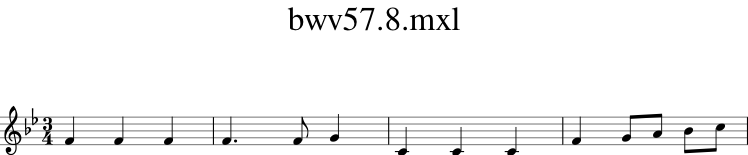

In [24]:
alto = sBach.parts[1] # parts count from zero, so soprano is 0 and alto is 1
excerpt = alto.measures(1, 4)
excerpt.show()

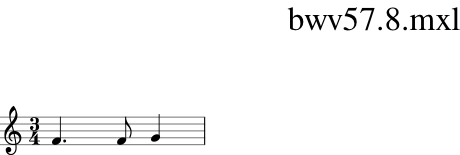

In [25]:
measure2 = alto.measure(2) # measure not measure_s_
measure2.show()

What is great about `.measure()` and `.measures()` is that they can work on a whole score and not just a single part.  Sometimes computational musicologists and programmers call a collection of measures across parts a "measureStack".  So let's get the measure stack consisting of measure numbers 2 and 3 across all parts:

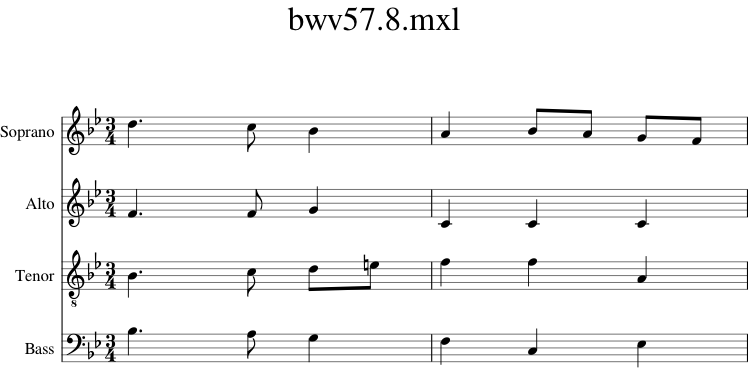

In [26]:
measureStack = sBach.measures(2, 3)
measureStack.show()

## Recursion in Streams

`Streams` are hierarchical objects where the contained elements can themselves be Streams.  In order to get at each lower layer of the stream, a generator method on every stream called :meth:`~music21.stream.Stream.recurse` will visit every element in the stream, starting from the beginning, and if any of the subelements are also Streams, they will visit every element in that Stream.

Let's create a simpler Stream to visualize what `.recurse()` does.

In [27]:
s = stream.Score(id='mainScore')
p0 = stream.Part(id='part0')
p1 = stream.Part(id='part1')

m01 = stream.Measure(number=1)
m01.append(note.Note('C', type="whole"))
m02 = stream.Measure(number=2)
m02.append(note.Note('D', type="whole"))
p0.append([m01, m02])

m11 = stream.Measure(number=1)
m11.append(note.Note('E', type="whole"))
m12 = stream.Measure(number=2)
m12.append(note.Note('F', type="whole"))
p1.append([m11, m12])

s.insert(0, p0)
s.insert(0, p1)
s.show('text')

{0.0} <music21.stream.Part part0>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.note.Note C>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note D>
{0.0} <music21.stream.Part part1>
    {0.0} <music21.stream.Measure 1 offset=0.0>
        {0.0} <music21.note.Note E>
    {4.0} <music21.stream.Measure 2 offset=4.0>
        {0.0} <music21.note.Note F>


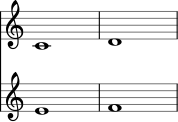

In [28]:
s.show()

Calling `.recurse()` on its own isn't very useful.

In [29]:
recurseScore = s.recurse()
recurseScore

<music21.stream.iterator.RecursiveIterator for Score:mainScore @:0>

Where it becomes useful is in a `for` loop:

In [30]:
for el in s.recurse():
    print(el.offset, el, el.activeSite)

0.0 <music21.stream.Score mainScore> None
0.0 <music21.stream.Part part0> <music21.stream.Score mainScore>
0.0 <music21.stream.Measure 1 offset=0.0> <music21.stream.Part part0>
0.0 <music21.note.Note C> <music21.stream.Measure 1 offset=0.0>
4.0 <music21.stream.Measure 2 offset=4.0> <music21.stream.Part part0>
0.0 <music21.note.Note D> <music21.stream.Measure 2 offset=4.0>
0.0 <music21.stream.Part part1> <music21.stream.Score mainScore>
0.0 <music21.stream.Measure 1 offset=0.0> <music21.stream.Part part1>
0.0 <music21.note.Note E> <music21.stream.Measure 1 offset=0.0>
4.0 <music21.stream.Measure 2 offset=4.0> <music21.stream.Part part1>
0.0 <music21.note.Note F> <music21.stream.Measure 2 offset=4.0>


This example also introduces the concept of `.activeSite`, which for now can be thought of as the Stream that the element lives in; though we'll find that `Notes` and other elements can be in multiple Streams simultaneously, and this is just the one that they are most recently associated with.

There are a lot of things that we can do with `.recurse()`, but let's just introduce one more thing for now.  Most "filtering" mechanisms, such as `.notes` can also be applied between the `()` of `recurse()` and the `:` at the end:

In [31]:
for el in s.recurse().notes:
    print(el.offset, el, el.activeSite)

0.0 <music21.note.Note C> <music21.stream.Measure 1 offset=0.0>
0.0 <music21.note.Note D> <music21.stream.Measure 2 offset=4.0>
0.0 <music21.note.Note E> <music21.stream.Measure 1 offset=0.0>
0.0 <music21.note.Note F> <music21.stream.Measure 2 offset=4.0>


In general, `.recurse()` is the best way to work through all the elements of a Stream, but there is another way that can be handy in some situations, and that is called `.flat`.

## Flattening a Stream

While nested Streams offer expressive flexibility, it is often useful to be able to flatten all Stream and Stream subclasses into a single Stream containing only the elements that are not Stream subclasses. The  :attr:`~music21.stream.Stream.flat` property provides immediate access to such a flat representation of a Stream. For example, doing a similar count of components, such as that show above, we see that we cannot get to all of the Note objects of a complete Score until we flatten its Part and Measure objects by accessing the `flat` attribute. Note that for historical reasons, `.flat` is a property, so you do not use `()` around it.

Let's look at what `.flat` does to the example score we created.

In [32]:
for el in s.flat:
    print(el.offset, el, el.activeSite)

0.0 <music21.note.Note C> <music21.stream.Score mainScore_flat>
0.0 <music21.note.Note E> <music21.stream.Score mainScore_flat>
4.0 <music21.note.Note D> <music21.stream.Score mainScore_flat>
4.0 <music21.note.Note F> <music21.stream.Score mainScore_flat>


A new, temporary `Stream` with `id` of "mainScore_flat" has been created, and all of the `Note` objects are in there.  We didn't filter out non-Notes: `.flat` automatically removes all `Stream` objects and in this case there's nothing else but Notes in there.

All the `Note` objects are now in the new temporary `mainScore_flat` object, and their offsets are no longer all `0.0`, but are instead measured from the start of the score being flattened.  So the whole notes in measure 2 are given offset `4.0`

Compare what `.flat` lets you do when looking at a larger score.

There are no Notes in the sBach stream...

In [33]:
len(sBach.getElementsByClass(note.Note))

0

...they are all inside Measures inside Parts inside the stream. (in a more complex score, they may be in Voices inside Measures inside Parts, etc.).  But they are all inside the flat version of the Stream:

In [34]:
len(sBach.flat.getElementsByClass(note.Note))

213

Element offsets are always relative to the Stream that contains them. For example, a Measure, when placed in a Stream, might have an offset of 16. This offset describes the position of the Measure in the Stream. Components of this Measure, such as Notes, have offset values relative only to their container, the Measure. The first Note of this Measure, then, has an offset of 0. In the following example we find that the offset of measure eight (using the :meth:`~music21.base.Music21Object.getOffsetBySite` method) is 21; the offset of the second Note in this Measure (index 1), however, is 1.

In [35]:
m = sBach.parts[0].getElementsByClass('Measure')[7]
m.getOffsetBySite(sBach.parts[0])

21.0

In [36]:
n = sBach.parts[0].measure(8).notes[1]
n

<music21.note.Note B->

In [37]:
n.getOffsetBySite(m)

1.0

Flattening a structure of nested Streams will set new, shifted offsets for each of the elements on the Stream, reflecting their appropriate position in the context of the Stream from which the `flat` property was accessed. For example, if a flat version of the first part of the Bach chorale is obtained, the note defined above has the appropriate offset of 22 (the Measure offset of 21 plus the Note offset within this Measure of 1). 


In [38]:
pFlat = sBach.parts[0].flat
indexN = pFlat.index(n)
pFlat[indexN]

<music21.note.Note B->

In [39]:
pFlat[indexN].offset

22.0

As an aside, it is important to recognize that the offset of the Note has not been edited; instead, a Note, as all Music21Objects, can store multiple pairs of sites and offsets. Music21Objects retain an offset relative to all Stream or Stream subclasses they are contained within, even if just in passing.

There's still a lot more to learn about `Streams`, but we can do that later. For now, let's move on to :ref:`Chapter 7: Chords <usersGuide_07_chords>`.